<a href="https://colab.research.google.com/github/aramsargsiann/Portfolio_2024/blob/main/Project2_imagedetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Hyper-parameters
num_epochs = 5
batch_size = 4
learning_rate = 0.001
# dataset has PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:
# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170498071/170498071 [00:03<00:00, 53891560.24it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


In [9]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)


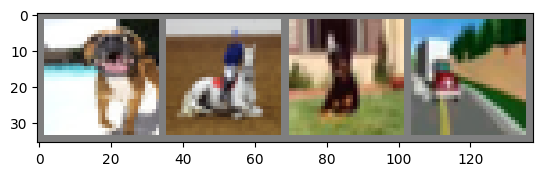

In [10]:
# show images
imshow(torchvision.utils.make_grid(images))

In [11]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # 3 input channels, 6 output channels, 5 kernel size
        self.pool = nn.MaxPool2d(2, 2)   # Max pooling with kernel size 2x2 and stride 2
        self.conv2 = nn.Conv2d(6, 16, 5) # 6 input channels, 16 output channels, 5 kernel size
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # Fully connected layer with 120 output features
        self.fc2 = nn.Linear(120, 84)         # Fully connected layer with 84 output features
        self.fc3 = nn.Linear(84, 10)           # Fully connected layer with 10 output features (10 classes)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 5, 5
        x = x.view(-1, 16 * 5 * 5)            # -> n, 400
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        x = self.fc3(x)                       # -> n, 10
        return x



In [12]:
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [13]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

Epoch [1/5], Step [2000/12500], Loss: 2.3379
Epoch [1/5], Step [4000/12500], Loss: 2.3135
Epoch [1/5], Step [6000/12500], Loss: 2.2642
Epoch [1/5], Step [8000/12500], Loss: 2.4116
Epoch [1/5], Step [10000/12500], Loss: 2.1407
Epoch [1/5], Step [12000/12500], Loss: 2.2030
Epoch [2/5], Step [2000/12500], Loss: 1.6112
Epoch [2/5], Step [4000/12500], Loss: 1.7203
Epoch [2/5], Step [6000/12500], Loss: 1.8181
Epoch [2/5], Step [8000/12500], Loss: 1.5809
Epoch [2/5], Step [10000/12500], Loss: 1.6878
Epoch [2/5], Step [12000/12500], Loss: 1.8831
Epoch [3/5], Step [2000/12500], Loss: 1.5178
Epoch [3/5], Step [4000/12500], Loss: 2.2770
Epoch [3/5], Step [6000/12500], Loss: 2.0052
Epoch [3/5], Step [8000/12500], Loss: 1.7533
Epoch [3/5], Step [10000/12500], Loss: 1.4232
Epoch [3/5], Step [12000/12500], Loss: 1.3109
Epoch [4/5], Step [2000/12500], Loss: 3.0859
Epoch [4/5], Step [4000/12500], Loss: 1.2821
Epoch [4/5], Step [6000/12500], Loss: 0.7502
Epoch [4/5], Step [8000/12500], Loss: 1.2528
Epoc

In [14]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')


Accuracy of the network: 47.98 %
Accuracy of plane: 55.7 %
Accuracy of car: 54.7 %
Accuracy of bird: 26.3 %
Accuracy of cat: 18.9 %
Accuracy of deer: 38.2 %
Accuracy of dog: 29.8 %
Accuracy of frog: 69.9 %
Accuracy of horse: 68.1 %
Accuracy of ship: 63.7 %
Accuracy of truck: 54.5 %


In [ ]:
# Results Are no that good cuze number of epochs is too low, u can increse and see the results